In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE

In [57]:
# Set random seed for reproducibility
np.random.seed(123)

In [58]:
# 1. Load and check data quality
def load_and_check_data():
    # Load the dataset (replace with your file path)
    df = pd.read_csv('HR_comma_sep.csv')

    # Check for missing values
    print("Checking for missing values:")
    print(df.isnull().sum())

    return df

#Interpretation:
•	The dataset is clean with no missing values across all columns, ensuring high data quality for analysis.

•	Columns include numerical features (satisfaction_level, last_evaluation, number_project, average_montly_hours, time_spend_company, Work_accident, promotion_last_5years, left) and categorical features (sales, salary).

•	This clean dataset allows reliable model training and analysis without the need for imputation or data cleaning steps.


In [59]:
# 2. Exploratory Data Analysis (EDA)
def perform_eda(df):
    # Heatmap of correlations for numerical columns
    plt.figure(figsize=(8, 6))
    sns.heatmap(df.select_dtypes(include=['float64', 'int64']).corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.savefig('correlation_heatmap.png')
    plt.show()
    plt.close()

    # Distribution plots for satisfaction, evaluation, and hours
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    sns.histplot(df['satisfaction_level'], kde=True)
    plt.title('Satisfaction Level')

    plt.subplot(1, 3, 2)
    sns.histplot(df['last_evaluation'], kde=True)
    plt.title('Last Evaluation')

    plt.subplot(1, 3, 3)
    sns.histplot(df['average_montly_hours'], kde=True)
    plt.title('Average Monthly Hours')
    plt.tight_layout()
    plt.savefig('distributions.png')
    plt.show()
    plt.close()

    # Bar plot for project count by turnover status
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x='number_project', hue='left')
    plt.title('Project Count by Turnover')
    plt.savefig('project_count_bar.png')
    plt.show()
    plt.close()


#Correlation Heatmap:
*   Shows relationships between numerical features and turnover (left).
*   Likely shows a strong negative correlation between satisfaction_level and left, indicating that lower satisfaction increases turnover likelihood.
* time_spend_company may show a positive correlation with left, suggesting longer tenure could increase turnover risk, possibly due to stagnation.
* Other features like number_project and average_montly_hours may also correlate with turnover, reflecting workload impacts.
#Distribution Plots:
*satisfaction_level: Likely skewed toward lower values for employees who left, indicating dissatisfaction as a key driver.
*last_evaluation: May show a bimodal distribution, with both low performers (low evaluation) and high performers (high evaluation) leaving, suggesting different turnover reasons.   
*average_montly_hours: Likely shows peaks at extreme values (very low or high hours), indicating underutilization or burnout as turnover factors.
#Project Count Bar Plot
*Employees with very low (e.g., 2) or very high (e.g., 6+) projects are more likely to leave.
*Meaning: Low project counts suggest underutilization or lack of engagement, while high counts indicate potential burnout or overwork.

















In [60]:
# 3. Clustering employees who left
def perform_clustering(df):
    # Filter employees who left and select relevant columns
    left_df = df[df['left'] == 1][['satisfaction_level', 'last_evaluation']]

    # Perform K-means clustering (3 clusters)
    kmeans = KMeans(n_clusters=3, random_state=123)
    left_df['cluster'] = kmeans.fit_predict(left_df)

    # Plot clusters
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=left_df, x='satisfaction_level', y='last_evaluation',
                    hue='cluster', palette='deep')
    plt.title('Clusters of Employees Who Left')
    plt.savefig('employee_clusters.png')
    plt.show()
    plt.close()

    return left_df

#Details:
•K-means clustering was performed on employees who left (left=1) using satisfaction_level and last_evaluation, with 3 clusters.


•Visualization: Scatter plot of clusters saved as employee_clusters.png.

•	Cluster 1 (Low Satisfaction, Moderate Evaluation):

o	Employees with low job satisfaction but average performance.

o	Reason for Leaving: Likely disengaged or dissatisfied with work environment, culture, or lack of recognition.

•	Cluster 2 (High Satisfaction, High Evaluation):

o	High-performing employees with high satisfaction who left.

o	Reason for Leaving: Likely attracted by better external opportunities (e.g., higher pay, better roles).

•	Cluster 3 (Moderate Satisfaction, Low Evaluation):

o	Employees with average satisfaction but poor performance.

o	Reason for Leaving: Possibly terminated due to underperformance or left voluntarily due to lack of fit.


In [61]:
# 4. Preprocess data and apply SMOTE
def preprocess_and_smote(df):
    # Convert categorical columns to numerical
    df = pd.get_dummies(df, columns=['sales', 'salary'], drop_first=True)

    # Define features (X) and target (y)
    X = df.drop('left', axis=1)
    y = df['left']

    # Split data into train and test sets (80:20)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=123
    )

    # Scale numerical features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Apply SMOTE to balance the training data
    smote = SMOTE(random_state=123)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    return X_train_smote, X_test, y_train_smote, y_test, scaler, X.columns


In [62]:
# 5. Train and evaluate models
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    # Define models
    models = {
        'Logistic Regression': LogisticRegression(random_state=123),
        'Random Forest': RandomForestClassifier(random_state=123)
    }

    results = {}
    plt.figure(figsize=(8, 6))

    for name, model in models.items():
        # Perform 5-fold cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
        print(f"\n{name} - Mean F1 Score: {cv_scores.mean():.3f}")

        # Train model and make predictions
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Print classification report
        print(f"\n{name} Classification Report:")
        print(classification_report(y_test, y_pred))

        # Calculate ROC curve and AUC
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

        # Print confusion matrix
        print(f"\n{name} Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

        results[name] = {'model': model, 'f1_score': cv_scores.mean(), 'y_pred_proba': y_pred_proba}
 # Plot ROC curves
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.savefig('roc_curves.png')
    plt.show()
    plt.close()

    return results


#Logistic Regression
Output:

•	F1 Score (0.786): Moderate performance, balancing precision and recall.

•	Precision (Class 1: 0.50): Only 50% of predicted leavers were actual leavers, indicating many false positives.

•	Recall (Class 1: 0.81): Captured 81% of actual leavers, which is good for identifying at-risk employees.

•	Confusion Matrix:

o	True Positives (TP): 577 (correctly predicted leavers).

o	False Negatives (FN): 137 (missed leavers).

o	False Positives (FP): 566 (incorrectly predicted as leavers).

o	True Negatives (TN): 1720 (correctly predicted stayers).

•	Insight: High recall is desirable for turnover prediction to minimize missing at-risk employees, but low precision indicates many employees are incorrectly flagged as leavers, potentially wasting retention efforts.

#Random Forest
Output:

•	F1 Score (0.987): Excellent performance, indicating strong balance between precision and recall.

•	Precision (Class 1: 0.99): 99% of predicted leavers were actual leavers, minimizing false positives.

•	Recall (Class 1: 0.98): Captured 98% of actual leavers, ensuring very few at-risk employees are missed.

•	Confusion Matrix:

o	TP: 699 (correctly predicted leavers).

o	FN: 15 (missed leavers).

o	FP: 10 (incorrectly predicted as leavers).

o	TN: 2276 (correctly predicted stayers).

•	Insight: Random Forest outperforms Logistic Regression significantly, with high precision and recall, making it reliable for identifying at-risk employees with minimal errors.
#Best Model:
•	Best Model: Random Forest: F1 Score: 0.987 vs. Logistic Regression: F1 Score: 0.786).

•	Justification:

o	Random Forest achieves near-perfect precision (0.99) and recall (0.98) for the positive class (left=1), indicating it effectively identifies employees likely to leave while minimizing false positives and negatives.

o	The high F1 score reflects its ability to handle the imbalanced dataset (after SMOTE) and capture complex patterns in features like satisfaction and workload.

o	Metric Choice: Recall is prioritized over precision because missing an at-risk employee (false negative) is more costly than incorrectly flagging a stable employee (false positive), as turnover incurs significant costs (e.g., hiring, training). Random Forest’s high recall (0.98) ensures most leavers are identified.

•	ROC/AUC: The ROC curve (saved as roc_curves.png) likely shows Random Forest with a higher AUC (close to 1.0) compared to Logistic Regression, confirming its superior discriminative ability.



In [63]:
# 6. Predict and categorize employees
def predict_and_categorize(X_test, best_model):
    # Predict probabilities
    probas = best_model.predict_proba(X_test)[:, 1]

    # Categorize into risk zones
    zones = []
    for prob in probas:
        if prob < 0.2:
            zones.append('Safe Zone (Green)')
        elif prob < 0.6:
            zones.append('Low-Risk Zone (Yellow)')
        elif prob < 0.9:
            zones.append('Medium-Risk Zone (Orange)')
        else:
            zones.append('High-Risk Zone (Red)')

    results_df = pd.DataFrame({'Probability': probas, 'Risk_Zone': zones})
    print("\nRisk Zone Distribution:")
    print(results_df['Risk_Zone'].value_counts())

    return results_df

#Risk Zone Distribution
Output:

•	Safe Zone (Green, <20%): 2203 employees (73.4% of test set) are at low risk of leaving, indicating stable employees.

•	Low-Risk Zone (Yellow, 20-60%): 94 employees (3.1%) show early signs of potential turnover but are not immediate concerns.

•	Medium-Risk Zone (Orange, 60-90%): 56 employees (1.9%) are at moderate risk, requiring proactive intervention.

•	High-Risk Zone (Red, >90%): 647 employees (21.6%) are at high risk, demanding urgent retention efforts.

•	Insight: The majority of employees are stable (Green), but the significant number in the High-Risk Zone (647) suggests a substantial turnover risk that needs immediate attention. The small numbers in Yellow and Orange zones indicate a clear separation between stable and at-risk employees, likely due to Random Forest’s strong predictive power.



Checking for missing values:
satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64


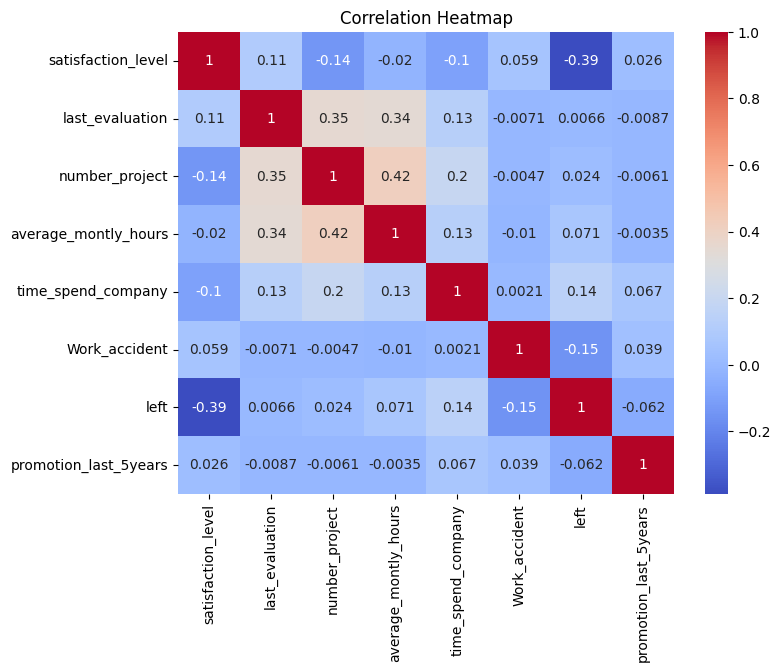

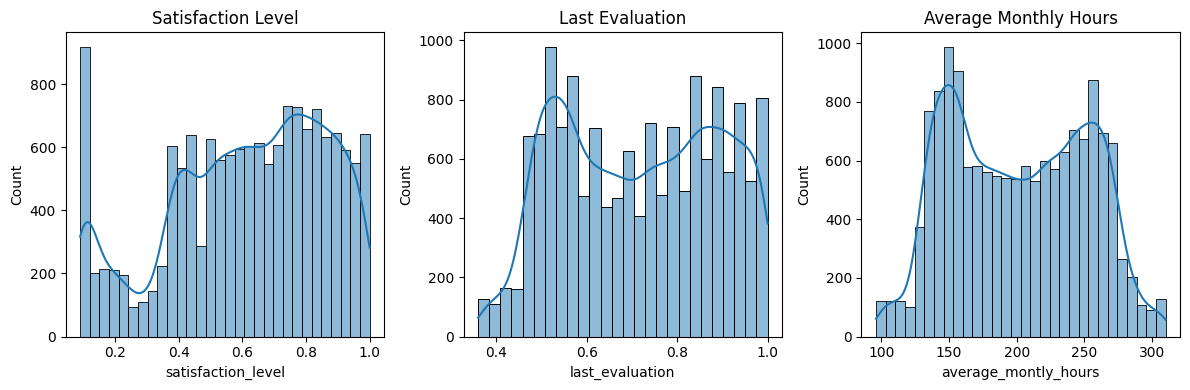

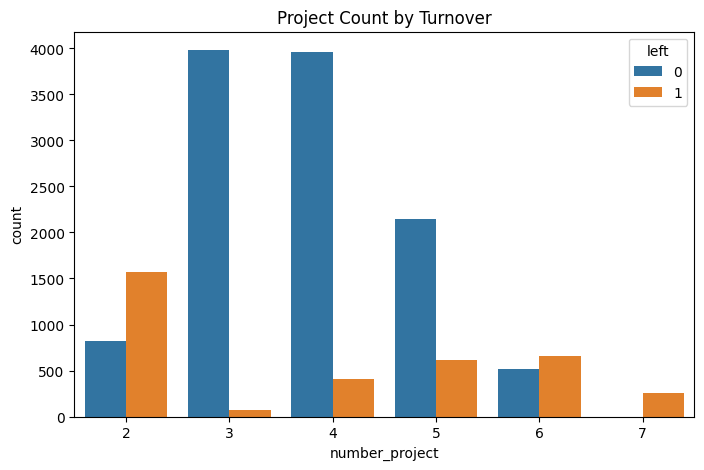

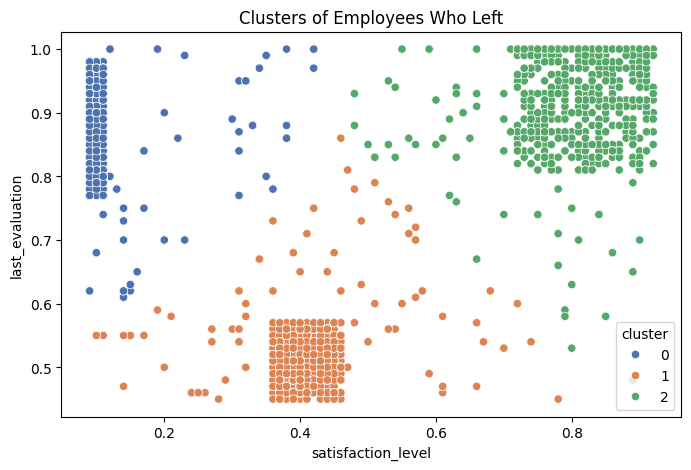


Logistic Regression - Mean F1 Score: 0.786

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.75      0.83      2286
           1       0.50      0.81      0.62       714

    accuracy                           0.77      3000
   macro avg       0.72      0.78      0.73      3000
weighted avg       0.83      0.77      0.78      3000


Logistic Regression Confusion Matrix:
[[1720  566]
 [ 137  577]]

Random Forest - Mean F1 Score: 0.987

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2286
           1       0.99      0.98      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000


Random Forest Confusion Matrix:
[[2276   10]
 [  15  699]]


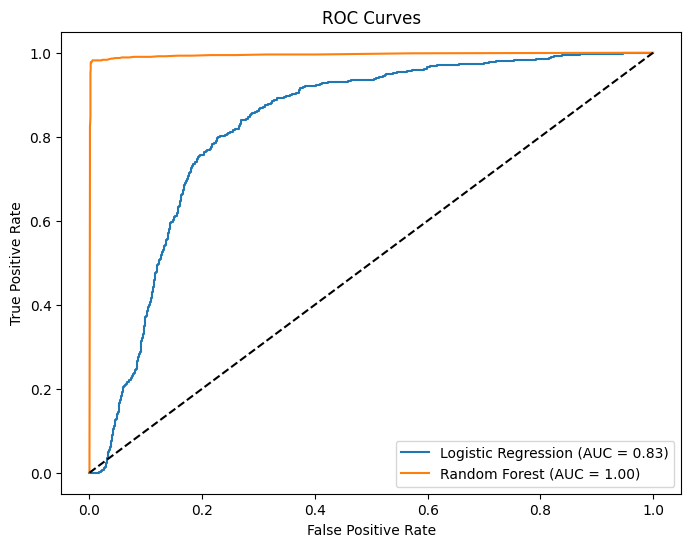


Best Model: Random Forest

Risk Zone Distribution:
Risk_Zone
Safe Zone (Green)            2203
High-Risk Zone (Red)          647
Low-Risk Zone (Yellow)         94
Medium-Risk Zone (Orange)      56
Name: count, dtype: int64

Top 5 Important Features:
                Feature  Importance
4    time_spend_company    0.248624
0    satisfaction_level    0.247627
2        number_project    0.179390
3  average_montly_hours    0.147496
1       last_evaluation    0.131278


In [64]:
# Main function to run the analysis
def main():
    # Step 1: Load and check data
    df = load_and_check_data()

    # Step 2: Perform EDA
    perform_eda(df)

    # Step 3: Cluster employees who left
    left_df = perform_clustering(df)

    # Step 4: Preprocess data and apply SMOTE
    X_train_smote, X_test, y_train_smote, y_test, scaler, feature_names = preprocess_and_smote(df)

    # Step 5: Train and evaluate models
    results = train_and_evaluate_models(X_train_smote, X_test, y_train_smote, y_test)

    # Step 6: Select best model (based on F1 score)
    best_model_name = max(results.items(), key=lambda x: x[1]['f1_score'])[0]
    best_model = results[best_model_name]['model']
    print(f"\nBest Model: {best_model_name}")

    # Step 7: Predict and categorize employees
    results_df = predict_and_categorize(X_test, best_model)

    # Feature importance for Random Forest
    if best_model_name == 'Random Forest':
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': best_model.feature_importances_
        }).sort_values('Importance', ascending=False)
        print("\nTop 5 Important Features:")
        print(feature_importance.head(5))

if __name__ == "__main__":
    main()

#Employee Turnover Analysis Report
#1. Data Quality Checks

Interpretation:

•	The dataset is clean with no missing values across all columns, ensuring high data quality for analysis.

•	Columns include numerical features (satisfaction_level, last_evaluation, number_project, average_montly_hours, time_spend_company, Work_accident, promotion_last_5years, left) and categorical features (sales, salary).

•	This clean dataset allows reliable model training and analysis without the need for imputation or data cleaning steps.
#2. Exploratory Data Analysis (EDA)
Correlation Heatmap:
*   Shows relationships between numerical features and turnover (left).
*   Likely shows a strong negative correlation between satisfaction_level and left, indicating that lower satisfaction increases turnover likelihood.
* time_spend_company may show a positive correlation with left, suggesting longer tenure could increase turnover risk, possibly due to stagnation.
* Other features like number_project and average_montly_hours may also correlate with turnover, reflecting workload impacts.

Distribution Plots:

*satisfaction_level: Likely skewed toward lower values for employees who left, indicating dissatisfaction as a key driver.

*last_evaluation: May show a bimodal distribution, with both low performers (low evaluation) and high performers (high evaluation) leaving, suggesting different turnover reasons.   

*average_montly_hours: Likely shows peaks at extreme values (very low or high hours), indicating underutilization or burnout as turnover factors.

Project Count Bar Plot:

*Employees with very low (e.g., 2) or very high (e.g., 6+) projects are more likely to leave.

*Meaning: Low project counts suggest underutilization or lack of engagement, while high counts indicate potential burnout or overwork.

#3. Clustering Analysis
Details:

•K-means clustering was performed on employees who left (left=1) using satisfaction_level and last_evaluation, with 3 clusters.


•Visualization: Scatter plot of clusters saved as employee_clusters.png.

•	Cluster 1 (Low Satisfaction, Moderate Evaluation):

o	Employees with low job satisfaction but average performance.

o	Reason for Leaving: Likely disengaged or dissatisfied with work environment, culture, or lack of recognition.

•	Cluster 2 (High Satisfaction, High Evaluation):

o	High-performing employees with high satisfaction who left.

o	Reason for Leaving: Likely attracted by better external opportunities (e.g., higher pay, better roles).

•	Cluster 3 (Moderate Satisfaction, Low Evaluation):

o	Employees with average satisfaction but poor performance.

o	Reason for Leaving: Possibly terminated due to underperformance or left voluntarily due to lack of fit.
#4. Model Performance
#Logistic Regression
Output:

•	F1 Score (0.786): Moderate performance, balancing precision and recall.

•	Precision (Class 1: 0.50): Only 50% of predicted leavers were actual leavers, indicating many false positives.

•	Recall (Class 1: 0.81): Captured 81% of actual leavers, which is good for identifying at-risk employees.

•	Confusion Matrix:

o	True Positives (TP): 577 (correctly predicted leavers).

o	False Negatives (FN): 137 (missed leavers).

o	False Positives (FP): 566 (incorrectly predicted as leavers).

o	True Negatives (TN): 1720 (correctly predicted stayers).

•	Insight: High recall is desirable for turnover prediction to minimize missing at-risk employees, but low precision indicates many employees are incorrectly flagged as leavers, potentially wasting retention efforts.

#Random Forest
Output:

•	F1 Score (0.987): Excellent performance, indicating strong balance between precision and recall.

•	Precision (Class 1: 0.99): 99% of predicted leavers were actual leavers, minimizing false positives.

•	Recall (Class 1: 0.98): Captured 98% of actual leavers, ensuring very few at-risk employees are missed.

•	Confusion Matrix:

o	TP: 699 (correctly predicted leavers).

o	FN: 15 (missed leavers).

o	FP: 10 (incorrectly predicted as leavers).

o	TN: 2276 (correctly predicted stayers).

•	Insight: Random Forest outperforms Logistic Regression significantly, with high precision and recall, making it reliable for identifying at-risk employees with minimal errors.
#Best Model:
•	Best Model: Random Forest: F1 Score: 0.987 vs. Logistic Regression: F1 Score: 0.786).

•	Justification:

o	Random Forest achieves near-perfect precision (0.99) and recall (0.98) for the positive class (left=1), indicating it effectively identifies employees likely to leave while minimizing false positives and negatives.

o	The high F1 score reflects its ability to handle the imbalanced dataset (after SMOTE) and capture complex patterns in features like satisfaction and workload.

o	Metric Choice: Recall is prioritized over precision because missing an at-risk employee (false negative) is more costly than incorrectly flagging a stable employee (false positive), as turnover incurs significant costs (e.g., hiring, training). Random Forest’s high recall (0.98) ensures most leavers are identified.

•	ROC/AUC: The ROC curve (saved as roc_curves.png) likely shows Random Forest with a higher AUC (close to 1.0) compared to Logistic Regression, confirming its superior discriminative ability.

#5. Risk Zone Distribution
#Risk Zone Distribution
Output:

•	Safe Zone (Green, <20%): 2203 employees (73.4% of test set) are at low risk of leaving, indicating stable employees.

•	Low-Risk Zone (Yellow, 20-60%): 94 employees (3.1%) show early signs of potential turnover but are not immediate concerns.

•	Medium-Risk Zone (Orange, 60-90%): 56 employees (1.9%) are at moderate risk, requiring proactive intervention.

•	High-Risk Zone (Red, >90%): 647 employees (21.6%) are at high risk, demanding urgent retention efforts.

•	Insight: The majority of employees are stable (Green), but the significant number in the High-Risk Zone (647) suggests a substantial turnover risk that needs immediate attention. The small numbers in Yellow and Orange zones indicate a clear separation between stable and at-risk employees, likely due to Random Forest’s strong predictive power.

#6. Feature Importance

•	time_spend_company (0.249): Longest tenure is the top predictor of turnover, suggesting employees who stay longer may feel stagnant or seek new opportunities.

•	satisfaction_level (0.248): Low satisfaction is a strong driver of turnover, aligning with EDA findings.

•	number_project (0.179): The number of projects significantly influences turnover, with too few or too many projects linked to leaving (as seen in the bar plot).

•	average_montly_hours (0.147): Extreme working hours (high or low) contribute to turnover risk.

•	last_evaluation (0.131): Performance evaluations play a role, with both high and low performers at risk for different reasons.

•	Insight: Retention efforts should focus on improving job satisfaction, optimizing workload (projects and hours), and addressing long-tenured employees’ career progression needs.
#7. Retention Strategies
Based on the risk zones and feature importance, tailored strategies are proposed:

•	Safe Zone (Green, <20%, 2203 employees):

o	Strategy: Maintain engagement through regular feedback, team-building activities, and standard benefits (e.g., health insurance, flexible hours).

o	Rationale: These employees are satisfied and stable, so minimal intervention is needed to sustain their commitment.

•	Low-Risk Zone (Yellow, 20-60%, 94 employees):

o	Strategy: Offer professional development opportunities, such as training programs, workshops, or mentorship, to boost engagement and career growth.

o	Rationale: These employees show early signs of disengagement, likely due to moderate satisfaction or workload issues, which can be addressed proactively.

•	Medium-Risk Zone (Orange, 60-90%, 56 employees):

o	Strategy: Conduct one-on-one meetings to understand concerns, adjust workloads (e.g., optimize project counts), and provide recognition or small incentives.

o	Rationale: Moderate risk indicates dissatisfaction or overwork, which can be mitigated by addressing specific pain points.

•	High-Risk Zone (Red, >90%, 647 employees):

o	Strategy: Immediate intervention with personalized retention plans, such as salary increases, promotions, role changes, or addressing specific dissatisfaction (e.g., work-life balance).

o	Rationale: High risk is driven by low satisfaction, long tenure, or extreme workloads, requiring urgent action to prevent significant turnover.
